# Integrantes:

- Noel Santiago Mendez Jaimes
- Zaira Maria Celis Rueda
- Ing. Jorge Luis Pinto Velandia



# Celda 1: Instalación e Importaciones

In [ ]:
!pip install opencv-contrib-python

import cv2
import numpy as np
import io
from PIL import Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Celda 2: Función de Captura (Incompleta en tu prompt anterior)
Esta función maneja la cámara del navegador y devuelve la imagen capturada.

In [ ]:
# --- Función de Utilidad para Capturar Cámara en Colab ---
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturar Rostro';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Esperar a que el usuario haga clic en el botón
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Celda 3: Lógica de Reconocimiento (Usando tu trainer.yml)
Esta lógica carga tu modelo, captura una imagen con la función anterior, y realiza la identificación.

Preparado para capturar y reconocer.


<IPython.core.display.Javascript object>

Rostro capturado y guardado como rostro_capturado.jpg
Rostros detectados: 1


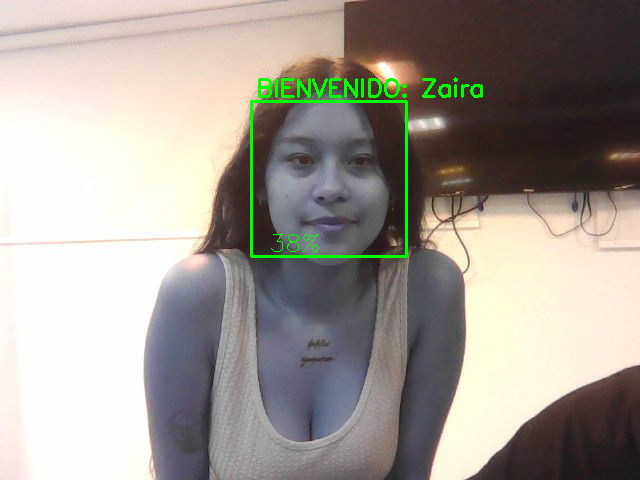

In [ ]:
# --- CONFIGURACIÓN DE RECONOCIMIENTO ---
names = {
    1: "Jorge",
    2: "Noel",
    3: "Zaira",
    0: "Desconocido"
}

# Cargar el modelo entrenador y el clasificador
recognizer = cv2.face.LBPHFaceRecognizer_create()
try:
    # Asegúrate de haber subido trainer.yml al entorno de Colab
    recognizer.read('trainer.yml')
except cv2.error:
    print("ERROR: No se pudo cargar el archivo trainer.yml. Asegúrate de haberlo subido al entorno de Colab.")
    exit()

# Usar el clasificador Haar Cascade para detección facial
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

if face_cascade.empty():
    print("ERROR: No se pudo cargar el clasificador Haar Cascade.")
    exit()

threshold = 85 # Precisión (menor es mejor)

# --- PROCESO DE CAPTURA Y RECONOCIMIENTO ---
print("Preparado para capturar y reconocer.")

# 1. Capturar la foto
try:
    filename = take_photo('rostro_capturado.jpg')
    print('Rostro capturado y guardado como {}'.format(filename))
except Exception as err:
    print(str(err))

# 2. Leer y procesar la imagen
img_pil = Image.open(filename)
img = np.array(img_pil)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 3. Detectar rostros
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor = 1.2,
    minNeighbors = 5,
    minSize = (100, 100)
)

print(f"Rostros detectados: {len(faces)}")

# 4. Reconocer
for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), 2)

    # Predecir ID y confianza
    id, confidence = recognizer.predict(gray[y:y+h, x:x+w])

    if (confidence < threshold):
        name = names.get(id, "Desconocido")
        status = f"BIENVENIDO: {name}"
        color = (0, 255, 0)
    else:
        name = "Desconocido"
        status = "ACCESO DENEGADO"
        color = (0, 0, 255)

    confidence_text = " {0}%".format(round(100 - confidence))

    cv2.putText(img, status, (x+5,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    cv2.putText(img, confidence_text, (x+5,y+h-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1)

# 5. Mostrar el resultado en Colab
from google.colab.patches import cv2_imshow
cv2_imshow(img)

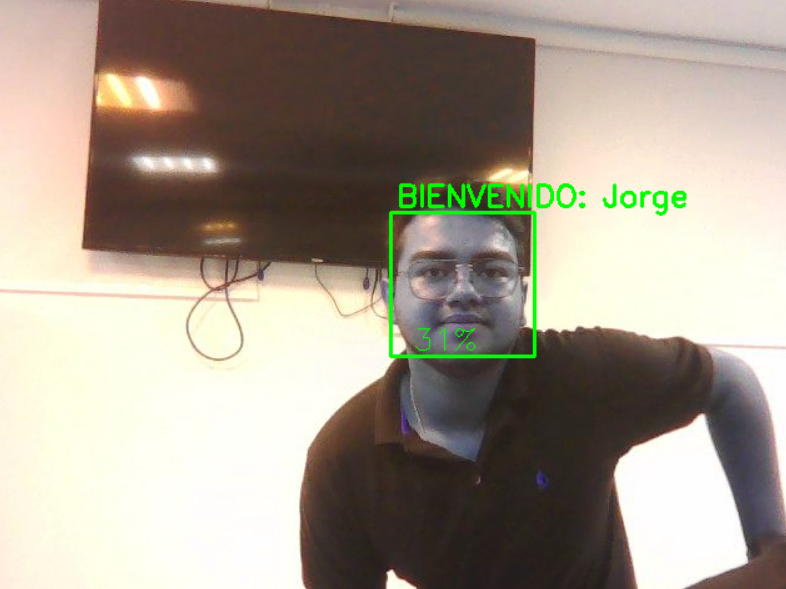

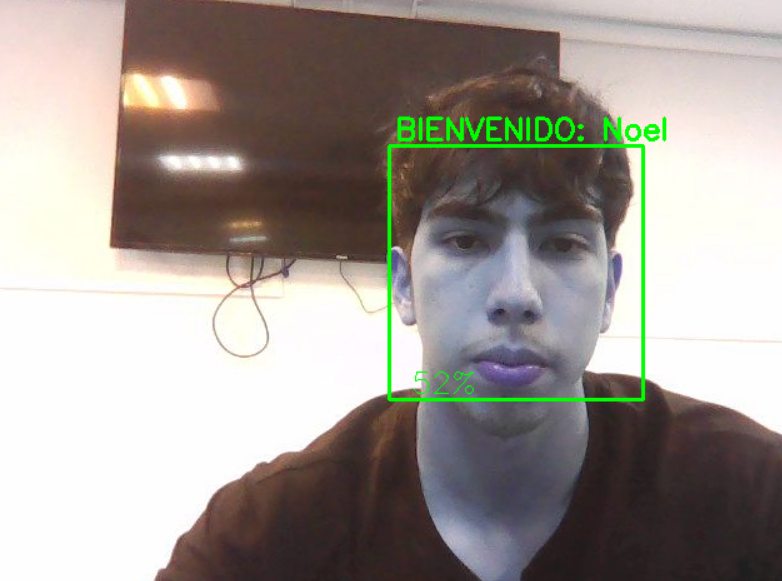

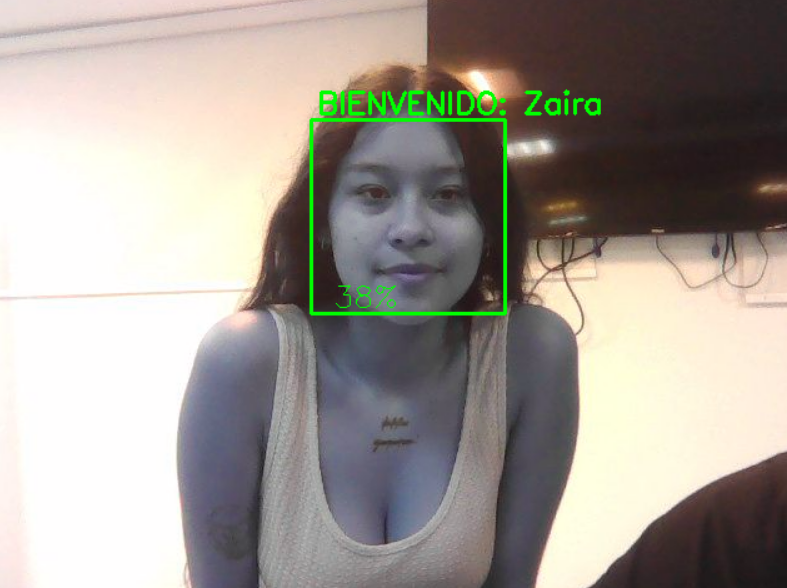

